<a href="https://colab.research.google.com/github/kla55/Pytorch_learning/blob/main/Pytorch_youtube/FreeCodeAcademy/05_PyTorch_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 4036 (delta 1069), reused 1087 (delta 998), pack-reused 2812
Receiving objects: 100% (4036/4036), 650.87 MiB | 24.41 MiB/s, done.
Resolving deltas: 100% (2362/2362), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7837f89888e0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

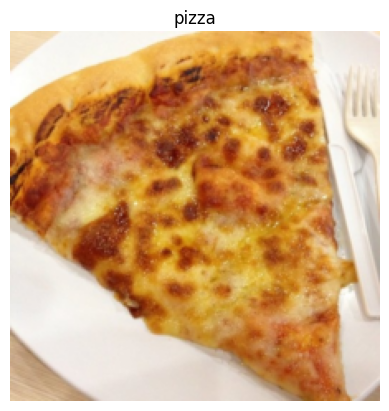

In [9]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [10]:
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

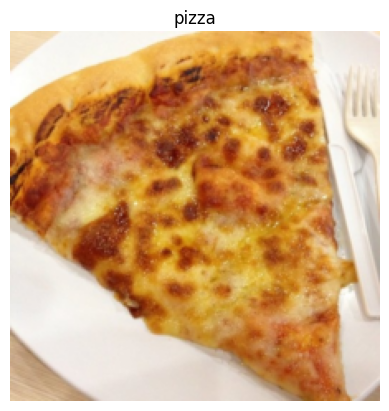

In [12]:
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

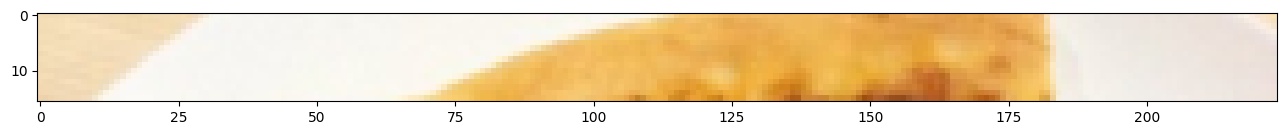

In [13]:
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


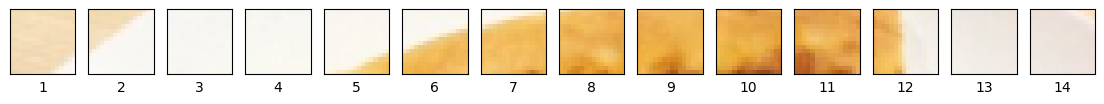

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


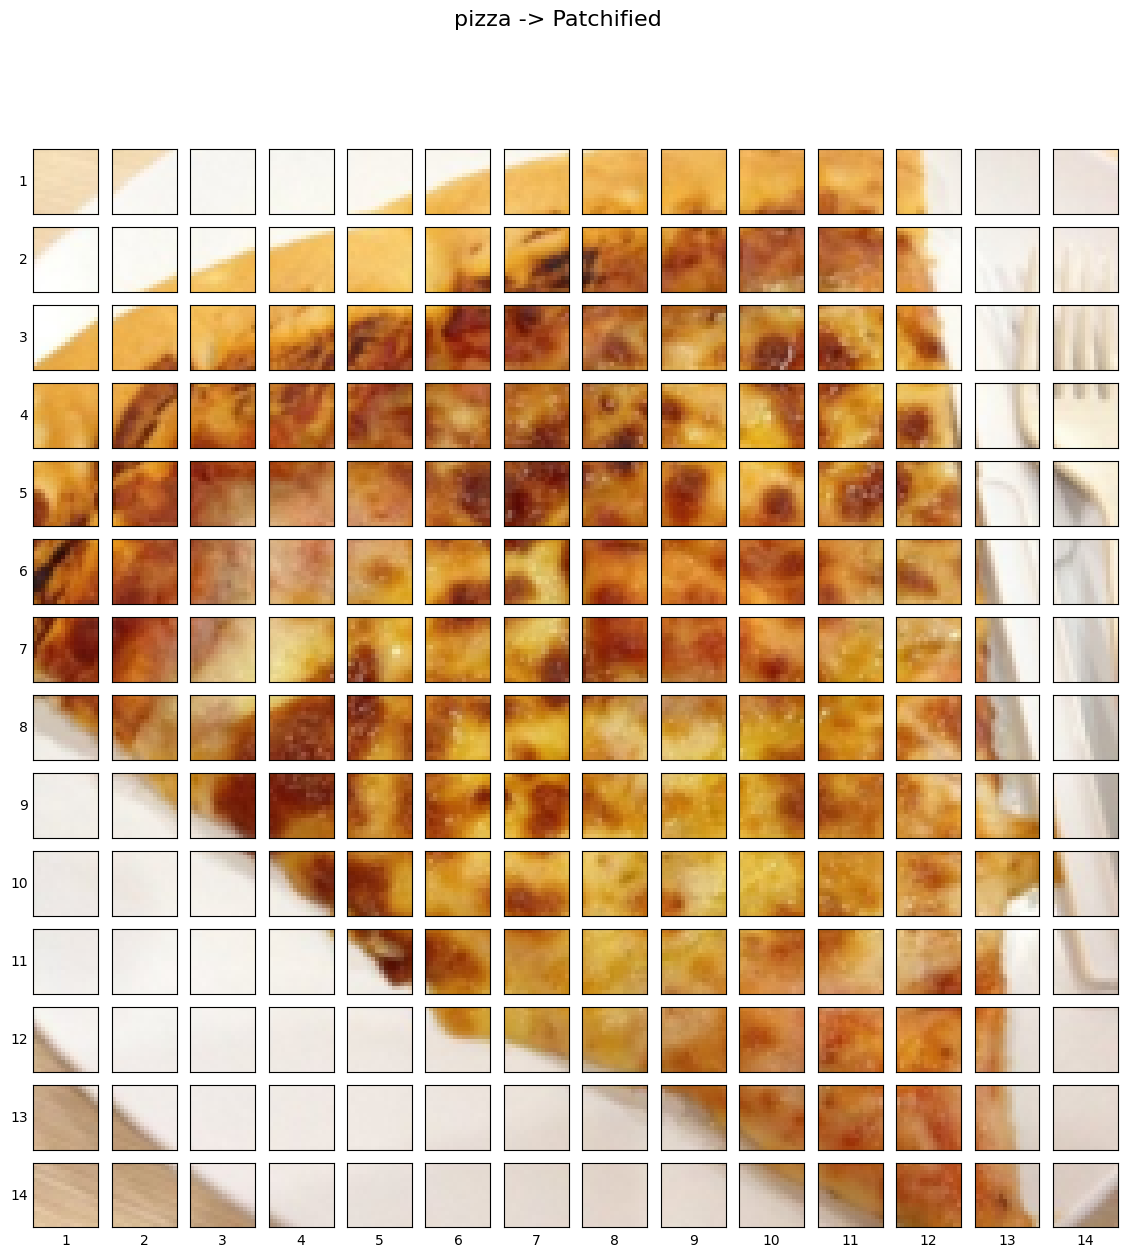

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [16]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

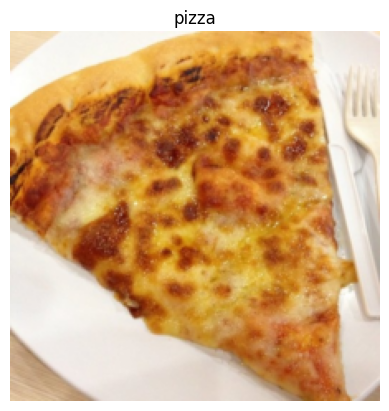

In [17]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image.shape)
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [683, 16, 728, 360, 132]


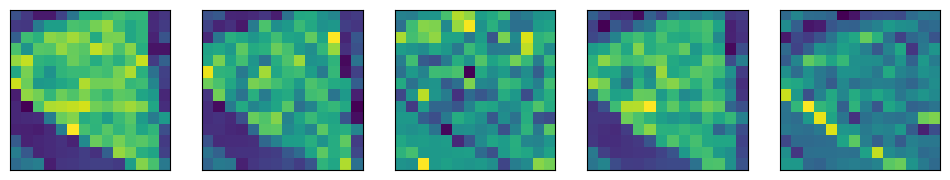

In [19]:
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [21]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0766, -0.0253, -0.0874, -0.0913, -0.1047, -0.1323, -0.1859,
           -0.0910, -0.0515, -0.0383, -0.0670,  0.0061, -0.0818, -0.0685],
          [-0.0266, -0.0837, -0.1065, -0.1979, -0.0954, -0.0193, -0.0774,
           -0.1008, -0.0694, -0.0874, -0.1515, -0.0155, -0.0713, -0.1245],
          [-0.1108, -0.1168,  0.0120, -0.0180, -0.1287, -0.1601, -0.0419,
           -0.0564, -0.0115,  0.0475, -0.0739,  0.0220, -0.1210, -0.0806],
          [-0.0233, -0.2927, -0.1018, -0.0774, -0.0645, -0.0635,  0.0156,
            0.0262, -0.0719, -0.1139, -0.0859,  0.0169, -0.1635, -0.0694],
          [-0.0412,  0.0210, -0.0661, -0.0533, -0.0552, -0.1571, -0.1378,
           -0.1110, -0.1188, -0.0879, -0.0795,  0.0028, -0.2199, -0.0036],
          [-0.1544, -0.0934, -0.0738, -0.1293, -0.0902,  0.0414, -0.0059,
           -0.0756, -0.0627, -0.1689, -0.0706, -0.0911, -0.0628, -0.0345],
          [-0.0882, -0.0730, -0.1128, -0.0334, -0.0066, -0.0272,  0.0361,
           -0.0571, -0.0891, -0.

In [22]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [23]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0)

    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)

In [24]:
set_seeds()

patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim= 768)

In [25]:
image.unsqueeze(0)

tensor([[[[0.9490, 0.9451, 0.9451,  ..., 0.9804, 0.9843, 0.9882],
          [0.9529, 0.9569, 0.9608,  ..., 0.9725, 0.9725, 0.9647],
          [0.9529, 0.9529, 0.9569,  ..., 0.9843, 0.9804, 0.9569],
          ...,
          [0.8588, 0.8706, 0.8667,  ..., 0.6353, 0.6392, 0.6392],
          [0.8902, 0.8784, 0.8667,  ..., 0.6392, 0.6510, 0.6588],
          [0.8784, 0.8980, 0.8980,  ..., 0.6471, 0.6510, 0.6824]],

         [[0.8627, 0.8588, 0.8588,  ..., 0.8941, 0.8902, 0.8941],
          [0.8667, 0.8706, 0.8745,  ..., 0.9020, 0.8902, 0.8824],
          [0.8667, 0.8667, 0.8706,  ..., 0.9294, 0.9176, 0.8980],
          ...,
          [0.7490, 0.7608, 0.7569,  ..., 0.5255, 0.5255, 0.5255],
          [0.7804, 0.7686, 0.7569,  ..., 0.5216, 0.5294, 0.5373],
          [0.7725, 0.7882, 0.7882,  ..., 0.5255, 0.5216, 0.5529]],

         [[0.7098, 0.7059, 0.7059,  ..., 0.7961, 0.7529, 0.7294],
          [0.7137, 0.7176, 0.7216,  ..., 0.8235, 0.7804, 0.7490],
          [0.7137, 0.7137, 0.7176,  ..., 0

In [26]:
patch_embedded_image = patchify(image.unsqueeze(0))

In [27]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [28]:
image.shape[-1]

224

In [29]:
224/ 16

14.0

In [30]:
16 * 16 * 3

768

In [31]:
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)

In [32]:
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [33]:
print(patch_embedded_image.shape)


torch.Size([1, 196, 768])


In [34]:
batch_size = patch_embedded_image.shape[0]
embedding_dimensions = patch_embedded_image.shape[-1]

In [35]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimensions,
                                      requires_grad=True))

In [36]:
print(class_token[:, :, :10])

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [37]:
class_token.shape

torch.Size([1, 1, 768])

In [38]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

In [39]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [40]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9529,  0.2277, -0.2422,  ...,  0.6521, -0.4120,  0.3373],
         [-0.9760,  0.3002, -0.3352,  ...,  0.7110, -0.3725,  0.3155],
         ...,
         [-0.5446,  0.0373, -0.0352,  ...,  0.2836, -0.2750,  0.1697],
         [-0.7652,  0.2217, -0.0344,  ...,  0.3649, -0.3667,  0.2196],
         [-0.7939,  0.1538, -0.1028,  ...,  0.5336, -0.4111,  0.2870]]],
       grad_fn=<CatBackward0>)

In [41]:
16**2 * 3

768

In [42]:
number_of_patches

196

In [43]:
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
embedding_dimension

768

In [44]:
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

In [45]:
print(position_embedding[:, :10, :10])

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [46]:
position_embedding.shape

torch.Size([1, 197, 768])

In [47]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.0471, 1.2277, 0.7578,  ..., 1.6521, 0.5880, 1.3373],
         [0.0240, 1.3002, 0.6648,  ..., 1.7110, 0.6275, 1.3155],
         ...,
         [0.4554, 1.0373, 0.9648,  ..., 1.2836, 0.7250, 1.1697],
         [0.2348, 1.2217, 0.9656,  ..., 1.3649, 0.6333, 1.2196],
         [0.2061, 1.1538, 0.8972,  ..., 1.5336, 0.5889, 1.2870]]],
       grad_fn=<AddBackward0>)


In [48]:
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [49]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [50]:
# Summary

set_seeds()

patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim= 768)

patch_embedded_image = patchify(image.unsqueeze(0))
print(patch_embedded_image.shape)

batch_size = patch_embedded_image.shape[0]
embedding_dimensions = patch_embedded_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,
                                      1,
                                      embedding_dimensions),
                                      requires_grad = True)
print(class_token.shape)

patch_embedding_class_token = torch.cat((class_token, patch_embedded_image), dim = 1)
print(patch_embedding_class_token.shape)


number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(patch_and_position_embedding.shape)

torch.Size([1, 196, 768])
torch.Size([1, 1, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [51]:
class MultiheadSelfAttentionBlock(nn.Module):

  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               attn_dropout: float = 0):

    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x)

    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output

In [52]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(patch_and_position_embedding.shape)
print(patched_image_through_msa_block.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [53]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               dropout: float = 0.1):

    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
               nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
               nn.GELU(),
               nn.Dropout(p=dropout),
               nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
               nn.Dropout(p=dropout)
               )

  def forward(self, x):
      x = self.layer_norm(x)
      x = self.mlp(x)
      return x

In [54]:
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(patched_image_through_msa_block.shape)
print(patched_image_through_mlp_block.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [55]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
                embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                num_heads:int=12, # Heads from Table 1 for ViT-Base
                mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                attn_dropout:float=0):

    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x

    x = self.mlp_block(x) + x

    return x



In [56]:
transformer_encoder_block = TransformerEncoderBlock()


In [57]:
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [58]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [59]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [60]:
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Training resolution from Table 3 in ViT paper
               in_channels:int=3, # Number of channels in input image
               patch_size:int=16, # Patch size
               num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:float=0, # Dropout for attention projection
               mlp_dropout:float=0.1, # Dropout for dense/MLP layers
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000):

    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

    self.num_patches = (img_size * img_size) // patch_size**2

    self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dimensions),
                                      requires_grad=True)


    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)


    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])


    self.classifier = nn.Sequential(
                                    nn.LayerNorm(normalized_shape=embedding_dim),
                                    nn.Linear(in_features=embedding_dim,
                                              out_features=num_classes)
                                    )

  def forward(self, x):

      batch_size = x.shape[0]
      class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)
      x = self.patch_embedding(x)
      x = torch.cat((class_token, x), dim=1)

      # 16. Add position embedding to patch embedding (equation 1)
      x = self.position_embedding + x

      # 17. Run embedding dropout (Appendix B.1)
      x = self.embedding_dropout(x)

      # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
      x = self.transformer_encoder(x)

      # 19. Put 0 index logit through classifier (equation 4)
      x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

      return x

In [61]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [62]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [63]:
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [64]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1949 | train_acc: 0.3633 | test_loss: 5.1213 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9517 | train_acc: 0.3320 | test_loss: 1.6205 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7585 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2245 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


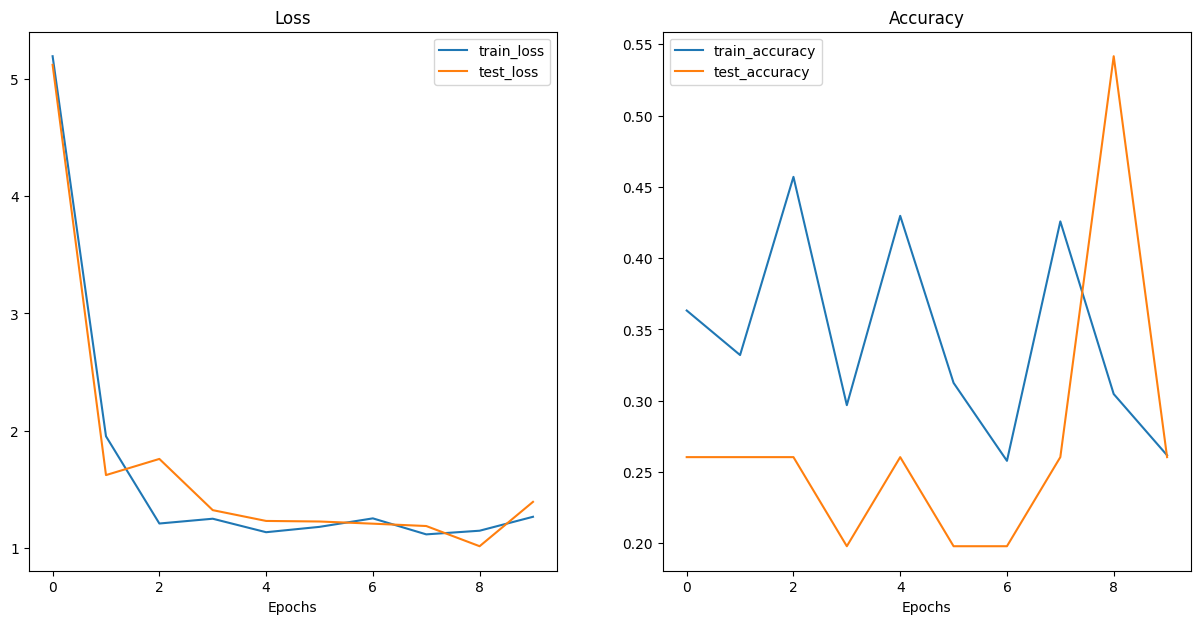

In [70]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [71]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [73]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 77.1MB/s]


In [74]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [75]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [76]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [77]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [78]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


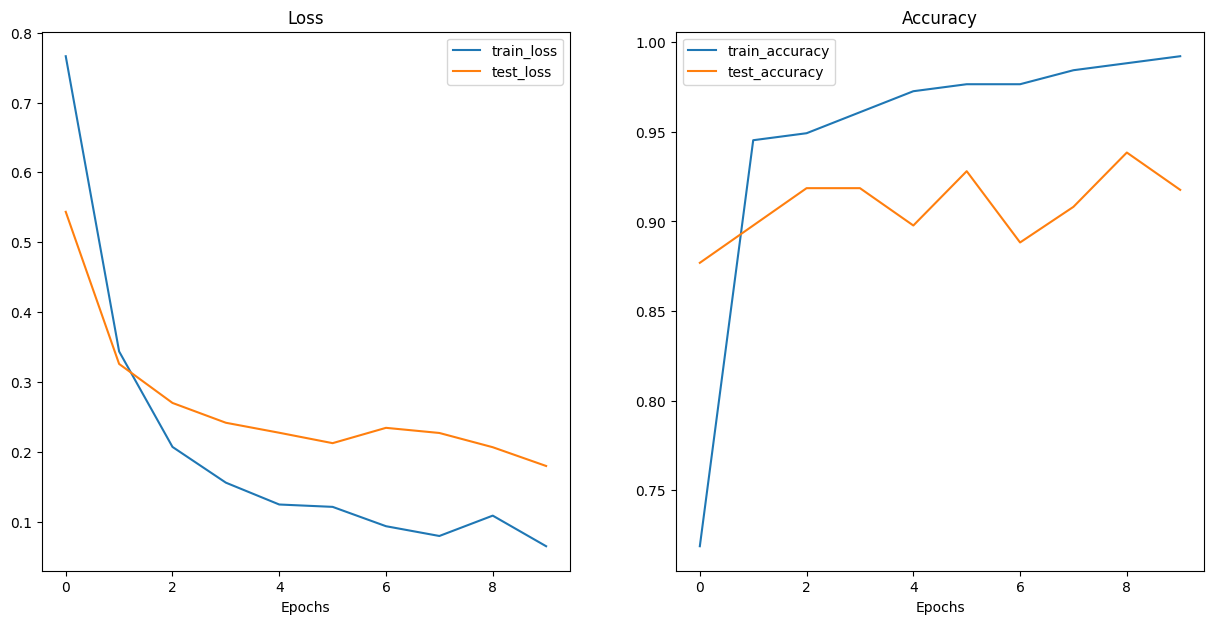

In [79]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

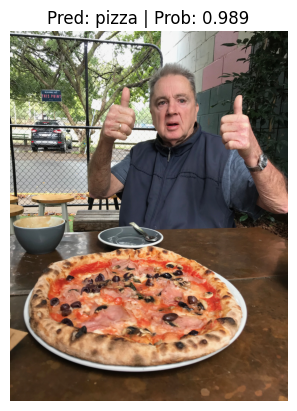

In [80]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)